# Preprocessing data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

**Parsing data from .csv file**

In [2]:
def data_extraction(filename):
    # pwm out data
    Data_pwm_out = pd.read_csv(filename + '_slash_mavros_slash_rc_slash_out.csv')
    secs = np.copy(Data_pwm_out.iloc[:,4])
    nsecs = np.copy(Data_pwm_out.iloc[:,5])
    bias = np.copy(secs[0])
    time_pwm_out = secs - bias + nsecs / 1e9
    pwm = Data_pwm_out.iloc[:,7]
    PWM = np.zeros([pwm.shape[0], 4])
    for i in range(pwm.shape[0]):
        s = pwm[i].split(',')
        for j in range(3):
            PWM[i, j + 1] =  int(s[j + 1])
        PWM[i, 0] = int(s[0].split('[')[1])
    PWM_Out = {'time': time_pwm_out, 'pwm out': PWM}
    
    # local position
    Data_local_pos = pd.read_csv(filename + '_slash_mavros_slash_local_position_slash_pose.csv')
    secs = np.copy(Data_local_pos.iloc[:,4])
    nsecs = np.copy(Data_local_pos.iloc[:,5])
    time_local_pos = secs - bias + nsecs / 1e9
    position_local_pos = np.copy(Data_local_pos.iloc[:,9:12])
    quaternion_local_pos = np.copy(Data_local_pos.iloc[:,13:])
    Local_Position = {'time': time_local_pos, 'position': position_local_pos, \
                 'quaternion': quaternion_local_pos}
    
    # local velocity
    Data_local_vel = pd.read_csv(filename + '_slash_mavros_slash_local_position_slash_velocity.csv')
    secs = np.copy(Data_local_vel.iloc[:,4])
    nsecs = np.copy(Data_local_vel.iloc[:,5])
    time_local_vel = secs - bias + nsecs / 1e9
    velocity_local_vel = np.copy(Data_local_vel.iloc[:,9:12])
    angular_rate_local_vel = np.copy(Data_local_vel.iloc[:,13:])
    Local_Velocity = {'time': time_local_vel, 'velocity': velocity_local_vel, \
                 'angular rate': angular_rate_local_vel}
    
    return PWM_Out, Local_Position, Local_Velocity

In [3]:
PWM_Out, Local_Position, Local_Velocity = data_extraction('./free_flying_low/')

In [4]:
print('PWM_Out sampling rate: ' + str(PWM_Out['pwm out'].shape[0] / (PWM_Out['time'][-1] - PWM_Out['time'][0])))
print('Local_Position sampling rate: ' + str(Local_Position['quaternion'].shape[0] / (Local_Position['time'][-1] - Local_Position['time'][0])))
print('Local_Velocity sampling rate: ' + str(Local_Velocity['velocity'].shape[0] / (Local_Velocity['time'][-1] - Local_Velocity['time'][0])))

rate_PWM = PWM_Out['pwm out'].shape[0] / (PWM_Out['time'][-1] - PWM_Out['time'][0])
rate_Local = Local_Position['quaternion'].shape[0] / (Local_Position['time'][-1] - Local_Position['time'][0])

PWM_Out sampling rate: 99.9180611614609
Local_Position sampling rate: 99.79842281888568
Local_Velocity sampling rate: 99.79842281888568


**Basic visualization**

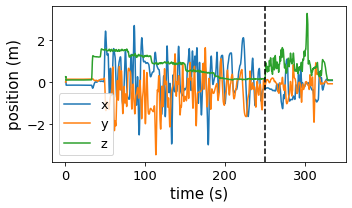

In [5]:
plt.figure(figsize=(5, 3))
line1, = plt.plot(Local_Position['time'], Local_Position['position'][:,0])
line2, = plt.plot(Local_Position['time'], Local_Position['position'][:,1])
line3, = plt.plot(Local_Position['time'], Local_Position['position'][:,2])
plt.xlabel("time (s)", fontsize = 15)
plt.ylabel("position (m)",  fontsize = 15)
#plt.title("Training data trajectory")
plt.legend([line1, line2, line3], ["x", "y", "z"], fontsize = 13)
plt.tick_params(labelsize = 13)
plt.axvline(x=250, color='k', linestyle='--')
plt.tight_layout()
#plt.savefig('training_data.pdf')
plt.show()

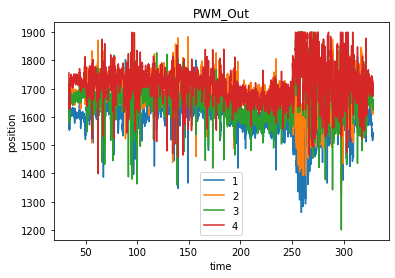

In [6]:
aa = 3300
bb = -600
line1, = plt.plot(PWM_Out['time'][aa:bb], PWM_Out['pwm out'][aa:bb,0])
line2, = plt.plot(PWM_Out['time'][aa:bb], PWM_Out['pwm out'][aa:bb,1])
line3, = plt.plot(PWM_Out['time'][aa:bb], PWM_Out['pwm out'][aa:bb,2])
line4, = plt.plot(PWM_Out['time'][aa:bb], PWM_Out['pwm out'][aa:bb,3])
plt.xlabel("time")
plt.ylabel("position")
plt.title("PWM_Out")
plt.legend([line1, line2, line3, line4], ["1", "2", "3", "4"])
plt.show()

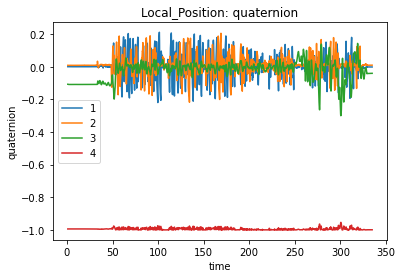

In [7]:
line1, = plt.plot(Local_Position['time'], Local_Position['quaternion'][:,0])
line2, = plt.plot(Local_Position['time'], Local_Position['quaternion'][:,1])
line3, = plt.plot(Local_Position['time'], Local_Position['quaternion'][:,2])
line4, = plt.plot(Local_Position['time'], Local_Position['quaternion'][:,3])
plt.xlabel("time")
plt.ylabel("quaternion")
plt.title("Local_Position: quaternion")
plt.legend([line1, line2, line3, line4], ["1", "2", "3", "4"])
plt.show()

**Interpolation**

To make sure the sampling rate is a constant number (100)

Q: quaternion
P: PWM_Out
V: velocity
A_d: acceleration from derivative

In [8]:
t0 = 35
t1 = 325
time = np.linspace(t0, t1, 100 * (t1 - t0) + 1)
Position = np.zeros((time.shape[0], 3))
Q = np.zeros((time.shape[0], 4))
P = np.zeros((time.shape[0], 4))
V = np.zeros((time.shape[0], 3))
W = np.zeros((time.shape[0], 3))
for i in range(time.shape[0]):
    if not i % 5000:
        print(i)
    t = time[i]
    
    bb = 0.5
    
    r = rate_Local
    cc = Local_Velocity['time'][0]
    t_ref = Local_Velocity['time'] - t
    left_time = np.max([n + t for n in t_ref[int(np.floor((t-bb-cc)*r)):int(np.ceil((t+bb-cc)*r))] if n < 0])
    right_time = np.min([n + t for n in t_ref[int(np.floor((t-bb-cc)*r)):int(np.ceil((t+bb-cc)*r))] if n > 0])
    left_index = np.where(Local_Velocity['time'] == left_time)[0]
    right_index = np.where(Local_Velocity['time'] == right_time)[0]
    left = Local_Velocity['velocity'][left_index, :]
    right = Local_Velocity['velocity'][right_index, :]
    V[i, :] = left + (right - left) * (t - left_time) / (right_time - left_time)
    
    left = Local_Velocity['angular rate'][left_index, :]
    right = Local_Velocity['angular rate'][right_index, :]
    W[i, :] = left + (right - left) * (t - left_time) / (right_time - left_time)
    
    r = rate_Local
    cc = Local_Position['time'][0]
    t_ref = Local_Position['time'] - t
    left_time = np.max([n + t for n in t_ref[int(np.floor((t-bb-cc)*r)):int(np.ceil((t+bb-cc)*r))] if n < 0])
    right_time = np.min([n + t for n in t_ref[int(np.floor((t-bb-cc)*r)):int(np.ceil((t+bb-cc)*r))] if n > 0])
    left_index = np.where(Local_Position['time'] == left_time)[0]
    right_index = np.where(Local_Position['time'] == right_time)[0]
    left = Local_Position['quaternion'][left_index, :]
    right = Local_Position['quaternion'][right_index, :]
    Q[i, :] = left + (right - left) * (t - left_time) / (right_time - left_time)
    
    left = Local_Position['position'][left_index, :]
    right = Local_Position['position'][right_index, :]
    Position[i, :] = left + (right - left) * (t - left_time) / (right_time - left_time)
    
    r = rate_PWM
    cc = PWM_Out['time'][0]
    t_ref = PWM_Out['time'] - t
    left_time = np.max([n + t for n in t_ref[int(np.floor((t-bb-cc)*r)):int(np.ceil((t+bb-cc)*r))] if n < 0])
    right_time = np.min([n + t for n in t_ref[int(np.floor((t-bb-cc)*r)):int(np.ceil((t+bb-cc)*r))] if n > 0])
    left_index = np.where(PWM_Out['time'] == left_time)[0]
    right_index = np.where(PWM_Out['time'] == right_time)[0]
    left = PWM_Out['pwm out'][left_index, :]
    right = PWM_Out['pwm out'][right_index, :]
    P[i, :] = left + (right - left) * (t - left_time) / (right_time - left_time)

0
5000
10000
15000
20000
25000


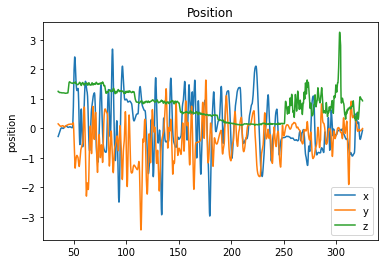

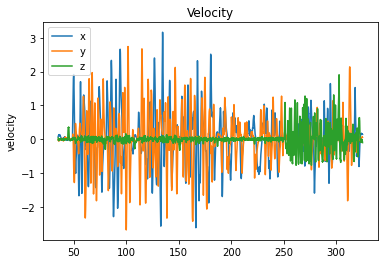

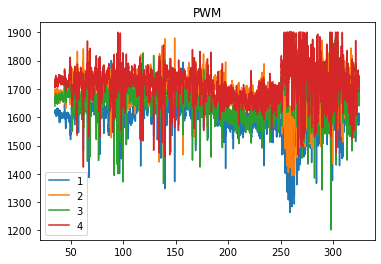

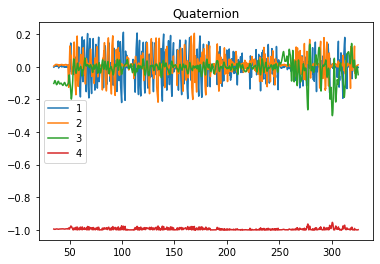

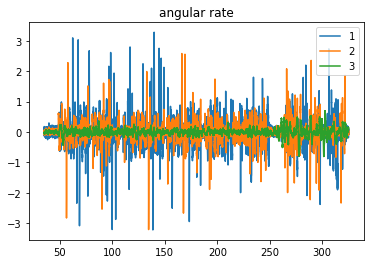

In [9]:
line1, = plt.plot(time[:], Position[:, 0])
line2, = plt.plot(time[:], Position[:, 1])
line3, = plt.plot(time[:], Position[:, 2])
plt.ylabel("position")
plt.title("Position")
plt.legend([line1, line2, line3], ["x", "y", "z"])
plt.show()

line1, = plt.plot(time[:], V[:, 0])
line2, = plt.plot(time[:], V[:, 1])
line3, = plt.plot(time[:], V[:, 2])
plt.ylabel("velocity")
plt.title("Velocity")
plt.legend([line1, line2, line3], ["x", "y", "z"])
plt.show()

line1, = plt.plot(time[:], P[:, 0])
line2, = plt.plot(time[:], P[:, 1])
line3, = plt.plot(time[:], P[:, 2])
line4, = plt.plot(time[:], P[:, 3])
plt.title('PWM')
plt.legend([line1, line2, line3, line4], ["1", "2", "3", "4"])
plt.show()

line1, = plt.plot(time[:], Q[:, 0])
line2, = plt.plot(time[:], Q[:, 1])
line3, = plt.plot(time[:], Q[:, 2])
line4, = plt.plot(time[:], Q[:, 3])
plt.title('Quaternion')
plt.legend([line1, line2, line3, line4], ["1", "2", "3", "4"])
plt.show()

line1, = plt.plot(time[:], W[:, 0])
line2, = plt.plot(time[:], W[:, 1])
line3, = plt.plot(time[:], W[:, 2])
plt.title('angular rate')
plt.legend([line1, line2, line3], ["1", "2", "3"])
plt.show()

**Get acceleration from derivative**

In [10]:
A_d = np.zeros((time.shape[0], 3))
A_d[2:-2,0] = (-V[4:,0] + 8 * V[3:-1,0] - 8 * V[1:-3,0] + V[:-4,0]) / 12 * 100
A_d[2:-2,1] = (-V[4:,1] + 8 * V[3:-1,1] - 8 * V[1:-3,1] + V[:-4,1]) / 12 * 100
A_d[2:-2,2] = (-V[4:,2] + 8 * V[3:-1,2] - 8 * V[1:-3,2] + V[:-4,2]) / 12 * 100

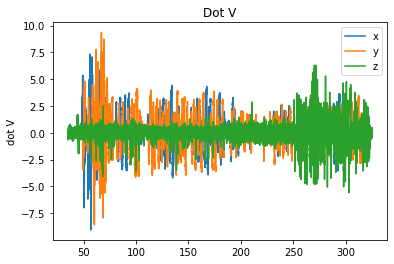

In [11]:
line1, = plt.plot(time[:], A_d[:, 0])
line2, = plt.plot(time[:], A_d[:, 1])
line3, = plt.plot(time[:], A_d[:, 2])
plt.ylabel("dot V")
plt.title("Dot V")
plt.legend([line1, line2, line3], ["x", "y", "z"])
plt.show()

**Get RPM**

In [12]:
RPM = np.zeros((time.shape[0], 4))
a1 = -0.0026
a2 = 17.0948
a3 = -14834.1065
RPM[:, 0] = a1 * P[:, 0] * P[:, 0] + a2 * P[:, 0] + a3 
RPM[:, 1] = a1 * P[:, 1] * P[:, 1] + a2 * P[:, 1] + a3 
RPM[:, 2] = a1 * P[:, 2] * P[:, 2] + a2 * P[:, 2] + a3 
RPM[:, 3] = a1 * P[:, 3] * P[:, 3] + a2 * P[:, 3] + a3

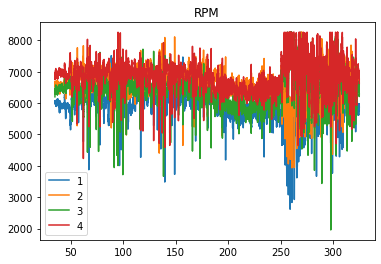

In [13]:
line1, = plt.plot(time[:], RPM[:, 0])
line2, = plt.plot(time[:], RPM[:, 1])
line3, = plt.plot(time[:], RPM[:, 2])
line4, = plt.plot(time[:], RPM[:, 3])
plt.title('RPM')
plt.legend([line1, line2, line3, line4], ["1", "2", "3", "4"])
plt.show()

In [14]:
rpm2 = np.sqrt(RPM[:, 0]**2 + RPM[:, 1]**2 + RPM[:, 2]**2 + RPM[:, 3]**2) / 2

**Get rotation matrix R**

In [15]:
# Convert quaternion to rotation matrix
def rotation_matrix(quat):
    rot_mat = np.ones([3,3])
    a = quat[0]**2
    b = quat[1]**2
    c = quat[2]**2
    d = quat[3]**2
    e = quat[0]*quat[1]
    f = quat[0]*quat[2]
    g = quat[0]*quat[3]
    h = quat[1]*quat[2]
    i = quat[1]*quat[3]
    j = quat[2]*quat[3]
    rot_mat[0,0] = a - b - c + d
    rot_mat[0,1] = 2 * (e - j)
    rot_mat[0,2] = 2 * (f + i)
    rot_mat[1,0] = 2 * (e + j)
    rot_mat[1,1] = -a + b - c + d
    rot_mat[1,2] = 2 * (h - g)
    rot_mat[2,0] = 2 * (f - i)
    rot_mat[2,1] = 2 * (h + g)
    rot_mat[2,2] = -a - b + c + d
    
    return rot_mat

In [16]:
R = np.zeros([time.shape[0], 3, 3])

In [17]:
for i in range(time.shape[0]):
    R[i, :, :] = rotation_matrix(Q[i, :])

**Fixed CT to get Fa**

In [20]:
m = 1.47
g = 9.81
rho = 1.225
D = 0.23
rpm2rs = 60 ** 2

C_t_fixed = 0.08937873049125099
Fa = np.zeros([time.shape[0], 3])
F = R[:, :, 2]

In [21]:
for i in range(time.shape[0]):
    temp = m * A_d[i, :]
    temp[2] += m * g
    r_square = RPM[i, 0]**2 + RPM[i, 1]**2 + RPM[i, 2]**2 + RPM[i, 3]**2
    thrust = C_t_fixed / rpm2rs * rho * D ** 4 * r_square
    Fa[i, :] = temp - thrust * F[i, :]

**Take a look at Fa**

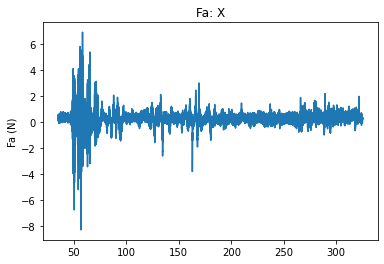

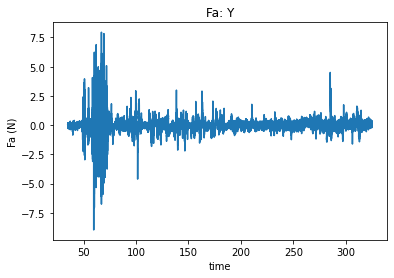

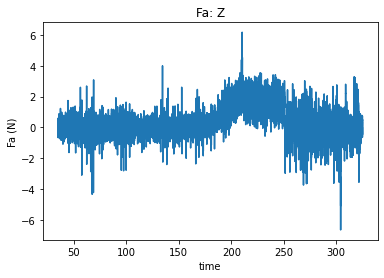

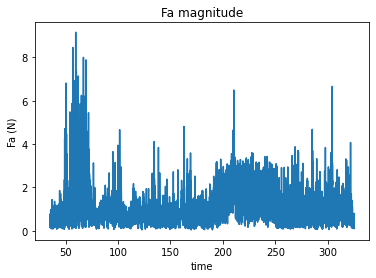

In [23]:
line1, = plt.plot(time[:], Fa[:, 0])
plt.title("Fa: X")
plt.ylabel("Fa (N)")
plt.show()

line1, = plt.plot(time[:], Fa[:, 1])
plt.title("Fa: Y")
plt.xlabel("time")
plt.ylabel("Fa (N)")
plt.show()

line1, = plt.plot(time[:], Fa[:, 2])
plt.title("Fa: Z")
plt.xlabel("time")
plt.ylabel("Fa (N)")
plt.show()

Fa_norm = np.zeros(time.shape[0])
for i in range(time.shape[0]):
    Fa_norm[i] = np.linalg.norm(Fa[i, :])
line1, = plt.plot(time[:], Fa_norm)
plt.title("Fa magnitude")
plt.xlabel("time")
plt.ylabel("Fa (N)")
plt.show()

# Learn Fa
Input: z; v; q; w; u

Output: Fa

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_tensor_type('torch.DoubleTensor')

**Data collection and normalization**

In [25]:
start = 0
L = time.shape[0] - start
data_input = np.zeros([L, 12])
data_output = np.zeros([L, 3])
data_input[:, 0] = Position[start:, 2]
data_input[:, 1:4] = V[start:, :]
data_input[:, 4:8] = Q[start:, :]
data_input[:, 8:12] = RPM[start:, :]
# data_input[:, 12:] = W[start:, :]
data_output[:] = Fa[start:, :] 

data_input[:, 8:12] = data_input[:, 8:12] / 8000

print(data_input.shape)
print(data_output.shape)

(29001, 12)
(29001, 3)


**Data shuffle and split**

In [26]:
Data_input = torch.from_numpy(data_input)
Data_output = torch.from_numpy(data_output)
print(Data_input.shape)
print(Data_output.shape)

torch.Size([29001, 12])
torch.Size([29001, 3])


In [27]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):

    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        Input = self.inputs[idx,]
        output = self.outputs[idx,]
        sample = {'input': Input, 'output': output}

        return sample

In [28]:
wholeset = MyDataset(Data_input, Data_output)
trainset, testset = torch.utils.data.dataset.random_split(wholeset, [23000, 6001])

In [29]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, num_workers=2)

**Net, optimizer and loss**

In [30]:
# Fa net
class Fa_Net(nn.Module):
    def __init__(self):
        super(Fa_Net, self).__init__()
        self.fc1 = nn.Linear(12, 25)
        self.fc2 = nn.Linear(25, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
fa_net = Fa_Net()

In [31]:
criterion = nn.MSELoss()
optimizer = optim.Adam(fa_net.parameters())

**Training**

In [32]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs = data['input']
        labels = data['output']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = fa_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Lip
        for param in fa_net.parameters():
            M = param.detach().numpy()
            if M.ndim > 1:
                u, s, vh = np.linalg.svd(M)
                if s[0] > 2:
                    param.data = param / s[0] * 2
        
        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 0.336
[1,  1000] loss: 0.233
[2,   500] loss: 0.223
[2,  1000] loss: 0.222
[3,   500] loss: 0.233
[3,  1000] loss: 0.217
[4,   500] loss: 0.214
[4,  1000] loss: 0.225
[5,   500] loss: 0.225
[5,  1000] loss: 0.214
Finished Training


In [33]:
train_loss = 0
test_loss = 0
with torch.no_grad():
    for i in range(23000):
        inputs = trainset[i]['input'] 
        label = trainset[i]['output']
        loss = criterion(fa_net(inputs), label)
        train_loss += loss.item()
    for i in range(6001):
        inputs = testset[i]['input'] 
        label = testset[i]['output']
        loss = criterion(fa_net(inputs), label)
        test_loss += loss.item()

In [34]:
print(train_loss / 23000)
print(test_loss / 6001)

0.21763561393350755
0.2214048341196779


**Heat map**

In [35]:
fa_net.load_state_dict(torch.load('Fa_net_12_3_full_Lip16.pth'))

<All keys matched successfully>

In [36]:
fa_net_1 = Fa_Net()
fa_net_1.load_state_dict(torch.load('Fa_net_12_3_full_Lip79.pth'))

<All keys matched successfully>

In [37]:
z = np.linspace(1.5,0,151)
v = np.linspace(-2,1,301)
fa_heatmap = np.zeros([151,301])
fa_heatmap_1 = np.zeros([151,301])
for j in range(301):
    for i in range(151):
        a = np.zeros([1,12])
        a[0,0] = z[i]
        a[0,1] = 0
        a[0,2] = 0
        a[0,3] = v[j]
        a[0,7] = 1
        a[0,8:12] = 0.8 
        aa = torch.from_numpy(a)
        fa_heatmap[i, j] = fa_net(aa)[0, 2].item()
        fa_heatmap_1[i, j] = fa_net_1(aa)[0, 2].item()

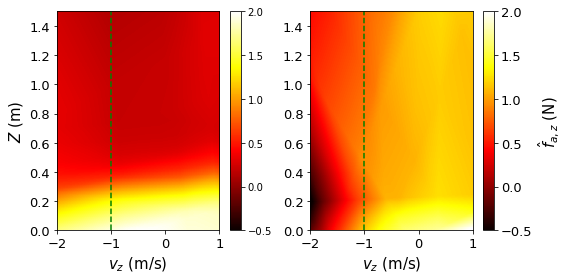

In [38]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
# plt.title(r'Heatmap of Learned ${\mathbf{f}_a}_z$ (with SN)', fontsize = 13)
plt.ylabel(r'$Z$ (m)', fontsize = 15)
plt.xlabel(r'$v_z$ (m/s)', fontsize = 15)
h1 = plt.imshow(fa_heatmap, cmap='hot', extent=[-2,1,0,1.5], aspect='auto')
plt.axvline(x=-1, color='g', linestyle='--')
plt.tick_params(labelsize = 13)
cbar = plt.colorbar(h1)
plt.clim(vmin=-0.5,vmax=2)
#cbar.set_label('Fa_z (N)')

plt.subplot(1, 2, 2)
# plt.title(r'Heatmap of Learned ${\mathbf{f}_a}_z$ (without SN)', fontsize = 13)
plt.xlabel(r'$v_z$ (m/s)', fontsize = 15)
h2 = plt.imshow(fa_heatmap_1, cmap='hot', extent=[-2,1,0,1.5], aspect='auto')
plt.axvline(x=-1, color='g', linestyle='--')
plt.tick_params(labelsize = 13)
plt.clim(vmin=-0.5,vmax=2)
cbar2 = plt.colorbar(h2)
cbar2.set_label(r'$\hat{f}_{a,z}$ (N)', fontsize = 15)
cbar2.ax.tick_params(labelsize = 13)

#plt.colorbar()
plt.tight_layout()
# plt.savefig('learned_fa_full.pdf')
plt.show()